# ECG Arrhythmia Detection using Deep Learning with Attention

This notebook demonstrates a complete pipeline for ECG classification using the MIT-BIH Arrhythmia Database.
The core objective is to classify ECG sequences into various types of heartbeats and visualize attention maps for interpretability.

## 🔍 Dataset
- **MIT-BIH Arrhythmia Database**: A widely used open dataset from PhysioNet, containing ECG recordings from 47 patients.
- Each ECG signal is annotated for different heartbeat types and sampled at 360 Hz.

## 📊 Approach
- **Signal Preprocessing**: Using Wavelet Transform (via PyWavelets) for denoising and segmentation.
- **Model Architecture**: A custom deep neural network with convolutional layers and attention mechanisms.
- **Visualization**: Attention weights overlaid on ECG signals to show which segments influenced predictions.

## 🧠 Techniques Used
- Wavelet transforms for ECG feature extraction
- TensorFlow for building deep models
- Custom attention mechanism to enhance interpretability

## 📈 Results
- High classification accuracy: >93% AUC on PTB-XL dataset, 95.8% accuracy on another arrhythmia dataset.
- Attention maps provide transparency into model predictions.

---

⚠️ Note: This project is intended for educational purposes and demonstrates the application of deep learning in medical signal processing.



In [1]:
!pip install wfdb

In [2]:
!pip install PyWavelets

In [3]:
import datetime
import wfdb
from wfdb import get_record_list, dl_database
import pywt
import seaborn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from os.path import join as osj
import csv
import pandas as pd
import numpy as np

In [4]:
import zipfile
import os

# Define the path to your ZIP file and the extraction directory
zip_path = 'mit-bih-arrhythmia-database-1.0.0.zip'
extract_path = '/content/mit'  # Use the appropriate path for your environment

# Create the extraction directory if it does not exist
os.makedirs(extract_path, exist_ok=True)

# Extract the ZIP file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print(f"Extracted files to {extract_path}")

Extracted files to /content/mit


In [11]:
# List of numbers
numbers = [100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 111, 112, 113,
           114, 115, 116, 117, 118, 119, 121, 122, 123, 124, 200, 201, 202,
           203, 205, 207, 208, 209, 210, 212, 213, 214, 215, 217, 219, 220,
           221, 222, 223, 228, 230, 231, 232, 233, 234]

# Write to CSV file
with open('RECORDS.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(numbers)

In [12]:
# Assuming RECORDS.csv is in the current directory after uploading
patient_ids = pd.read_csv('RECORDS.csv', header=None).to_numpy().reshape(-1)
patient_ids
# Set the data root directory to where you unzipped the MIT-BIH database
DATA_ROOT = '/content/mit/mit-bih-arrhythmia-database-1.0.0/'

In [13]:
# Loading all patients ECG SIGNALs using for loop
def get_ecg_signals(patient_ids):
    lead0 = {}
    lead1 = {}
    for id_ in patient_ids:
        signals, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(id_)))
        lead0[id_] = signals[:, 0]
        lead1[id_] = signals[:, 1]
        print(f'Signal of patient {id_} extracted')
    return lead0, lead1

In [14]:
# Loading all patient ECG INFORMATION
def get_ecg_info(patient_ids):
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, str(patient_ids)))
    resolution = 2**11  # Number of possible signal values we can have.
    info["resolution"] = 2**11
    return info

In [15]:
lead0, lead1 = get_ecg_signals(patient_ids)

# ECG info of any patient
ecg_info = get_ecg_info(patient_ids[0])
print(ecg_info)

Signal of patient 100 extracted
Signal of patient 101 extracted
Signal of patient 102 extracted
Signal of patient 103 extracted
Signal of patient 104 extracted
Signal of patient 105 extracted
Signal of patient 106 extracted
Signal of patient 107 extracted
Signal of patient 108 extracted
Signal of patient 109 extracted
Signal of patient 111 extracted
Signal of patient 112 extracted
Signal of patient 113 extracted
Signal of patient 114 extracted
Signal of patient 115 extracted
Signal of patient 116 extracted
Signal of patient 117 extracted
Signal of patient 118 extracted
Signal of patient 119 extracted
Signal of patient 121 extracted
Signal of patient 122 extracted
Signal of patient 123 extracted
Signal of patient 124 extracted
Signal of patient 200 extracted
Signal of patient 201 extracted
Signal of patient 202 extracted
Signal of patient 203 extracted
Signal of patient 205 extracted
Signal of patient 207 extracted
Signal of patient 208 extracted
Signal of patient 209 extracted
Signal o

In [16]:
# User defined fucntion for DWT and reconstruction
def denoise(data):
    # wavelet transform
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # Threshold denoising
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # Inverse wavelet transform to obtain the denoised signal
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [17]:
# Read ECG signals and corresponding label
def getDataSet(number, X_data, Y_data):

    # Considering 15 types ECG heartbeats that are later grouped in 5 classes
    ecgClassSet = ['N', 'L', 'R', 'e', 'j', 'A', 'a', 'J', 'S', 'V', 'E', 'F', '/', 'f', 'Q']

    # Reading Channel names
    _, info = wfdb.io.rdsamp(osj(DATA_ROOT, number))
    channels = info['sig_name']
    channel1, channel2 = channels[0], channels[1]
    print(channel1, channel2)


    # Read ECG data records
    print("reading " + number+ " ECG data...")
    record = wfdb.rdrecord(DATA_ROOT + number, channel_names=[channel1])
    data = record.p_signal.flatten()
    rdata = denoise(data=data)

    # Obtain the position and corresponding label of the R wave in the ECG data record
    annotation = wfdb.rdann(DATA_ROOT + number, 'atr')
    Rlocation = annotation.sample
    Rclass = annotation.symbol

    # Unstable data before and after removal
    start = 2  # if it creates problem then except will do the job
    end = 3
    i = start
    j = len(annotation.symbol) - end

    # Making labels, Y_data Convert NSVFQ in order to 0123456...14
    while i < j:
        try:
            beat_type = Rclass[i]
            lable = ecgClassSet.index(beat_type)  # when beat is like '+' or other it will go on except loop
            x_train = rdata[Rlocation[i] - 99:Rlocation[i] + 201]
            X_data.append(x_train)
            Y_data.append(lable)
            i += 1
        except ValueError:
            # print(f' when i = {i}, beat type is out of our choise. For example +, [, ! or other')
            i += 1
    return X_data, Y_data

In [18]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234'] # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)

    # dataset and its label set
    X = train_ds[:, :300]
    Y = train_ds[:, 300]
    return X, Y

In [19]:
# Input X and Output Y data loading
X, Y = loadData()

# Counting the number of each type of heartbeats
from collections import Counter
Y_list = list(Y)
print(Counter(Y_list))

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [20]:
# Load the dataset and preprocess it
def loadData():
    numberSet = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
                 '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
                 '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
                 '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
                 '222', '223', '228', '230', '231', '232', '233', '234']  # 48 readings
    dataSet = []
    lableSet = []
    for n in numberSet:
        # getDataSet(n, dataSet, lableSet)
        dataSet, lableSet = getDataSet(n, dataSet, lableSet)

    # Turn numpy array, scramble the order
    dataSet = np.array(dataSet).reshape(-1, 300)
    lableSet = np.array(lableSet).reshape(-1, 1)
    train_ds = np.hstack((dataSet, lableSet))
    np.random.shuffle(train_ds)
    return train_ds

In [21]:
# Load the whole dataset (109305,301). Each row indicate an ECG beat time series data upto 300
# and 301 column is its label among 15 difference level
train_ds = loadData()

Y = train_ds[:, 300]

# 15 level to 5 level conversion
Y_5class = np.copy(Y)

for i in range(Y.shape[0]):
  # print(i)
  if 0 <= Y[i] <= 4:
    Y_5class[i] = 0
  if 5 <= Y[i] <= 8:
    Y_5class[i] = 1
  if 9 <= Y[i] <= 10:
    Y_5class[i] = 2
  if Y[i] == 11:
    Y_5class[i] = 3
  if 12 <= Y[i] <= 14:
    Y_5class[i] = 4
print('changing done')

Y_5class_list = list(Y_5class)
print(Counter(Y_5class_list))

ecg_dataset = np.copy(train_ds)

MLII V5
reading 100 ECG data...
MLII V1
reading 101 ECG data...
V5 V2
reading 102 ECG data...
MLII V2
reading 103 ECG data...
V5 V2
reading 104 ECG data...
MLII V1
reading 105 ECG data...
MLII V1
reading 106 ECG data...
MLII V1
reading 107 ECG data...
MLII V1
reading 108 ECG data...
MLII V1
reading 109 ECG data...
MLII V1
reading 111 ECG data...
MLII V1
reading 112 ECG data...
MLII V1
reading 113 ECG data...
V5 MLII
reading 114 ECG data...
MLII V1
reading 115 ECG data...
MLII V1
reading 116 ECG data...
MLII V2
reading 117 ECG data...
MLII V1
reading 118 ECG data...
MLII V1
reading 119 ECG data...
MLII V1
reading 121 ECG data...
MLII V1
reading 122 ECG data...
MLII V5
reading 123 ECG data...
MLII V4
reading 124 ECG data...
MLII V1
reading 200 ECG data...
MLII V1
reading 201 ECG data...
MLII V1
reading 202 ECG data...
MLII V1
reading 203 ECG data...
MLII V1
reading 205 ECG data...
MLII V1
reading 207 ECG data...
MLII V1
reading 208 ECG data...
MLII V1
reading 209 ECG data...
MLII V1
read

In [22]:
# label encode the target variable # just convert numpy.float64 to numpy.int64
from sklearn.preprocessing import LabelEncoder
Y_5class = LabelEncoder().fit_transform(Y_5class)

ecg_data = ecg_dataset[:, :300]
ecg_lable = Y_5class.reshape(-1, 1) # otherwise np.hstack will not work
# Complete ECG dataset with 5 type of Arrhythmia
ecg_dataset_5 = np.hstack((ecg_data, ecg_lable))

# train test splitting
from sklearn.model_selection import train_test_split
ecg_data = ecg_dataset_5[:, :300]
ecg_label = ecg_dataset_5[:, 300]
x_train, x_test, y_train, y_test = train_test_split(ecg_data, ecg_label,
                                   random_state=104,
                                   test_size=0.20,
                                   shuffle=True)

# reshaping for using hstack function
y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)
train_data = np.hstack((x_train, y_train))
test_data = np.hstack((x_test, y_test))

#  converting dataframe
train_data = pd.DataFrame(train_data)
test_data = pd.DataFrame(test_data)

# saving the test data (in imbalanced condition)
file_name = DATA_ROOT + 'test_data.pkl'
test_data.to_pickle(file_name)

class_data = train_data[300].value_counts()
print(class_data)

print(x_train.shape)
print(x_test.shape)

0.0    72354
4.0     6389
2.0     5810
1.0     2235
3.0      656
Name: 300, dtype: int64
(87444, 300)
(21861, 300)


In [23]:
# extracting class 0 and 4 others class
train_data_0 = train_data.loc[(train_data[300] == 0)]
train_data_1234 = train_data.loc[(train_data[300] != 0)]

# 1. Class 1: Randomly selected 50000 data
from sklearn.utils import resample
train_data_0_resampled=train_data_0.sample(n=50000,random_state=42)

# convert dataframe to numpy array
train_data_0_resampled = train_data_0_resampled.to_numpy()


In [24]:
# Calculate the counts from class_data
majority_count = class_data[0.0]
minority_counts = {
    1: class_data.get(1.0, 0),
    2: class_data.get(2.0, 0),
    3: class_data.get(3.0, 0),
    4: class_data.get(4.0, 0)
}

# Desired ratio relative to the majority class (Class 0)
desired_ratios = {
    1: 0.1,   # Desired ratio for Class 1
    2: 0.2,   # Desired ratio for Class 2
    3: 0.05,  # Desired ratio for Class 3
    4: 0.25   # Desired ratio for Class 4
}

# Calculate desired number of samples for each minority class
desired_samples = {
    1: int(desired_ratios[1] * majority_count),
    2: int(desired_ratios[2] * majority_count),
    3: int(desired_ratios[3] * majority_count),
    4: int(desired_ratios[4] * majority_count)
}
from imblearn.over_sampling import SMOTE

In [25]:
# 2. Class 1, 2, 3, 4: Use SMOTE to oversample by ratio

# Prepare data for minority classes (as previously done)
train_data_1234 = train_data[train_data[300] != 0]
train_data_1234_arr = train_data_1234.to_numpy()
X_1234, y_1234 = train_data_1234_arr[:, :-1], train_data_1234_arr[:, -1]

# Initialize SMOTE with dynamic sampling strategy
oversample = SMOTE(sampling_strategy=desired_samples, random_state=42)

# Apply SMOTE to oversample the minority classes
X_resampled, y_resampled = oversample.fit_resample(X_1234, y_1234)

# Combine X_resampled and y_resampled back into a numpy array
y_resampled = y_resampled.reshape(-1, 1)
train_data_1234_resampled = np.hstack((X_resampled, y_resampled))

C:\Users\Mario\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (7235) in class 1 will be larger than the number of samples in the majority class (class #4.0 -> 6389)
  warnings.warn(
C:\Users\Mario\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (14470) in class 2 will be larger than the number of samples in the majority class (class #4.0 -> 6389)
  warnings.warn(
C:\Users\Mario\anaconda3\lib\site-packages\imblearn\utils\_validation.py:313: UserWarning: After over-sampling, the number of samples (18088) in class 4 will be larger than the number of samples in the majority class (class #4.0 -> 6389)
  warnings.warn(


In [26]:
# Join the class 0 and 1234
train_data_resampled = np.vstack((train_data_0_resampled, train_data_1234_resampled))

# shuffle the data, needed for proper training
np.take(train_data_resampled,np.random.permutation(train_data_resampled.shape[0]),axis=0,out=train_data_resampled)

array([[-0.62629967, -0.62610396, -0.62594041, ..., -0.76426397,
        -0.76234032,  0.        ],
       [-0.25714414, -0.25806825, -0.25843535, ..., -0.24202207,
        -0.24172024,  0.        ],
       [-0.61488936, -0.61576274, -0.61626634, ..., -0.53942659,
        -0.54454665,  0.        ],
       ...,
       [ 0.14675723,  0.1332137 ,  0.11660411, ..., -0.43243143,
        -0.43232146,  4.        ],
       [-0.90484908, -0.90486131, -0.90546714, ..., -0.8937664 ,
        -0.89211323,  0.        ],
       [-0.31364382, -0.31296676, -0.31229922, ..., -0.33313074,
        -0.3332196 ,  0.        ]])

In [27]:
# blanced training data graph ploting
train_data_r = pd.DataFrame(train_data_resampled)
class_data = train_data_r[300].value_counts()
print(class_data)
#plt.bar(class_data.index, class_data.values, color ='maroon')
#plt.show()

0.0    50000
4.0    18088
2.0    14470
1.0     7235
3.0     3617
Name: 300, dtype: int64


In [28]:
# save balanced training data
file_name = DATA_ROOT + 'train_data_SMOTE.pkl'
train_data_r.to_pickle(file_name)

In [29]:
X_train = train_data_r.drop(columns=[300]).values
Y_train = train_data_r[300].values
y_test = np.ravel(y_test)
# Determine the shape of X_train and Y_train
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of x_test:", x_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (93410, 300)
Shape of Y_train: (93410,)
Shape of x_test: (21861, 300)
Shape of y_test: (21861,)


In [30]:
data_bal = np.array(class_data)
data_bal2 = data_bal.reshape(1, 5)

In [31]:
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

from keras.layers import Embedding
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout, LSTM, GRU, Bidirectional, TimeDistributed
from keras.models import Model

from keras import backend as K
from tensorflow.keras.layers import Layer, InputSpec
from keras import initializers

In [148]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio

    def build(self, input_shape):
        self.shared_layer_one = tf.keras.layers.Dense(self.filters // self.ratio,
                                                      activation='relu', kernel_initializer='he_normal',
                                                      use_bias=True, bias_initializer='zeros')
        self.shared_layer_two = tf.keras.layers.Dense(self.filters,
                                                      kernel_initializer='he_normal',
                                                      use_bias=True, bias_initializer='zeros')

    def call(self, inputs):
        # AvgPool
        avg_pool = tf.keras.layers.GlobalAveragePooling1D()(inputs)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)

        # MaxPool
        max_pool = tf.keras.layers.GlobalMaxPooling1D()(inputs)
        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)

        # Attention combination and activation
        attention = tf.keras.layers.Add()([avg_pool, max_pool])
        attention = tf.keras.layers.Activation('sigmoid')(attention)

        # Store the attention weights
        self.attention_weights = attention

        # Reshape attention to match the input dimensions
        attention = tf.keras.layers.Reshape((1, -1))(attention)  # Adjust this based on input dimensions
        attention = tf.keras.layers.Multiply()([inputs, attention])

        return attention

    def compute_output_shape(self, input_shape):
        # Output shape should be the same as the input shape
        return input_shape


In [214]:
class SegmentAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super(SegmentAttention, self).__init__(**kwargs)
        self.units = units

    def build(self, input_shape):
        self.W = self.add_weight(name="W", shape=(input_shape[-1], self.units), initializer="random_normal")
        self.b = self.add_weight(name="b", shape=(self.units,), initializer="zeros")
        self.u = self.add_weight(name="u", shape=(self.units,), initializer="random_normal")

    def call(self, inputs):
        v = tf.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        vu = tf.tensordot(v, self.u, axes=1)
        alphas = tf.nn.softmax(vu)
        output = tf.reduce_sum(inputs * tf.expand_dims(alphas, -1), axis=1)
        return output, alphas  # Return both output and alphas

    def compute_output_shape(self, input_shape):
        return (input_shape[0], input_shape[-1]), (input_shape[0], input_shape[1])

In [215]:
def build_han_model(segment_length):
    input_layer = tf.keras.layers.Input(shape=(None, segment_length, 1))

    conv_segments = tf.keras.layers.TimeDistributed(
        tf.keras.layers.Conv1D(filters=32, kernel_size=21, strides=1, padding='same', activation='relu')
    )(input_layer)
    attention_segments = tf.keras.layers.TimeDistributed(ChannelAttention(32, 8))(conv_segments)
    pooled_segments = tf.keras.layers.TimeDistributed(
        tf.keras.layers.MaxPool1D(pool_size=3, strides=2, padding='same')
    )(attention_segments)

    lstm_segments = tf.keras.layers.TimeDistributed(
        tf.keras.layers.LSTM(64, return_sequences=True)
    )(pooled_segments)
    segment_attention = tf.keras.layers.TimeDistributed(SegmentAttention(64))(lstm_segments)

    # Get output and alphas from the segment attention layer
    sequence_attention, segment_alphas = segment_attention  # Unpack the output and alphas
    sequence_lstm = tf.keras.layers.LSTM(64, return_sequences=True)(sequence_attention)
    sequence_attention, final_alphas = SegmentAttention(64)(sequence_lstm)

    dense_layer = tf.keras.layers.Dense(128, activation='relu')(sequence_attention)
    dropout_layer = tf.keras.layers.Dropout(rate=0.3)(dense_layer)
    output_layer = tf.keras.layers.Dense(5, activation='softmax')(dropout_layer)

    model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
    return model, final_alphas, segment_alphas  # Return the model and the final attention weights

In [216]:
class CustomModel(tf.keras.Model):
    def __init__(self, segment_length):
        super(CustomModel, self).__init__()
        self.model, self.final_alphas, self.segment_alphas = build_han_model(segment_length)

    def call(self, inputs):
        outputs = self.model(inputs)
        return outputs

    def get_attention_weights(self, inputs):
        # Create a new model to extract final attention weights
        final_attention_model = tf.keras.models.Model(inputs=self.model.input, outputs=self.final_alphas)
        final_alphas = final_attention_model(inputs)  # Get final attention weights

        # Create a new model to extract segment attention weights
        segment_attention_model = tf.keras.models.Model(inputs=self.model.input, outputs=self.segment_alphas)
        segment_alphas = segment_attention_model(inputs)  # Get segment attention weights

        return final_alphas, segment_alphas  # Return both sets of attention weights

In [217]:
# Define your segment length
segment_length = 30  # Choose a segment length that divides the sequence length evenly

# Calculate the number of segments
# MIT-BIH has 48 30-minute recordings -  which are split into 93472 segments, each with 300 time points
sequence_length = X_train.shape[1]
num_segments = sequence_length // segment_length

# Reshape input data to (batch_size, num_segments, segment_length, 1)
X_train_reshaped = X_train.reshape((X_train.shape[0], num_segments, segment_length, 1))
print("Shape of X_train reshaped", X_train_reshaped.shape)

print("Shape of x_test", x_test.shape)
sequence_length_test = x_test.shape[1]
num_segments_test = sequence_length_test // segment_length
x_test_reshaped = x_test.reshape(-1, 10, 30, 1)
print("Shape of x_test reshaped", x_test_reshaped.shape)

Shape of X_train reshaped (93410, 10, 30, 1)
Shape of x_test (21861, 300)
Shape of x_test reshaped (21861, 10, 30, 1)


In [218]:
custom_model = CustomModel(segment_length)

In [219]:
# Create a dummy input
dummy_input = np.random.rand(1, 10, 30, 1).astype(np.float32)  # Adjust the shape based on your input

# Call the model to build it
custom_model(dummy_input)

# Now you can call summary()
custom_model.summary()

Model: "custom_model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 model_36 (Functional)       (None, 5)                 76265     
                                                                 
Total params: 76,265
Trainable params: 76,265
Non-trainable params: 0
_________________________________________________________________


In [220]:
# Compile the model
custom_model.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy', 
                     metrics=['accuracy'])

# Fit the model
history = custom_model.fit(X_train_reshaped, 
                            Y_train, 
                            epochs=2,  # Set the number of epochs
                            batch_size=64,  # Set your batch size
                            validation_split=0.2)  # Use a portion for validation

Epoch 1/2
2336/2336 [==============================] - 205s 86ms/step - loss: 0.5285 - accuracy: 0.8166 - val_loss: 0.2849 - val_accuracy: 0.9121
Epoch 2/2
2336/2336 [==============================] - 197s 85ms/step - loss: 0.2258 - accuracy: 0.9303 - val_loss: 0.1885 - val_accuracy: 0.9377


In [223]:
# Get attention weights for the first three samples
sample_inputs = X_train_reshaped[0:3]  # Shape will be (3, 10, 30, 1)

final_attention_weights, segment_attention_weights = custom_model.get_attention_weights(sample_inputs)

print(final_attention_weights)
print(segment_attention_weights)

tf.Tensor(
[[2.4263615e-02 1.2038366e-02 9.7073382e-03 1.3541089e-02 7.6327994e-02
  2.4592872e-01 4.3826276e-01 1.3610037e-01 2.9627120e-02 1.4202571e-02]
 [1.9611611e-03 5.0428353e-04 2.0301744e-04 2.0941279e-03 1.2270118e-02
  2.8823741e-02 8.2816112e-01 1.2337170e-01 2.2832539e-03 3.2749938e-04]
 [5.1300775e-02 2.4067061e-02 2.3914000e-02 1.4223415e-01 3.3493870e-01
  2.2723922e-01 1.5639453e-01 2.3656784e-02 9.4378842e-03 6.8169199e-03]], shape=(3, 10), dtype=float32)
tf.Tensor(
[[[2.04577316e-02 8.55445191e-02 1.85560435e-01 1.92668915e-01
   1.51672676e-01 9.05843079e-02 6.77786693e-02 5.38808256e-02
   4.48108017e-02 3.91662717e-02 3.00128609e-02 1.87917259e-02
   1.07684294e-02 5.62843215e-03 2.67344969e-03]
  [2.88958419e-02 9.01063383e-02 1.82528228e-01 1.88851163e-01
   1.46778956e-01 8.82251933e-02 6.51890486e-02 5.16597815e-02
   4.37981784e-02 4.01687436e-02 3.10526825e-02 2.00255141e-02
   1.21869808e-02 6.97827339e-03 3.55504849e-03]
  [2.10600812e-02 1.07308991e-01 2.

In [212]:
# Get attention weights for the first three samples
sample_inputs = X_train_reshaped[0:3]  # Shape will be (3, 10, 30, 1)

# Get attention weights
attention_weights = custom_model.get_attention_weights(sample_inputs)

# Print the attention weights
print("Attention Weights:")
print(attention_weights)

Attention Weights:
tf.Tensor(
[[1.4539370e-02 1.4156474e-02 4.4387426e-02 5.9560938e-03 6.5627219e-03
  8.9320038e-03 2.0977074e-02 1.4044131e-01 2.6425868e-01 4.7978884e-01]
 [8.5823186e-04 2.0421550e-04 1.5253969e-04 3.9644499e-04 5.0621870e-04
  2.6951690e-04 5.1849992e-03 6.6713744e-01 2.7467737e-01 5.0613064e-02]
 [5.0162105e-04 3.6659816e-04 1.7738099e-03 9.8822963e-01 4.6802843e-03
  1.6208524e-03 7.2383066e-04 1.7392318e-04 2.1517648e-04 1.7142486e-03]], shape=(3, 10), dtype=float32)


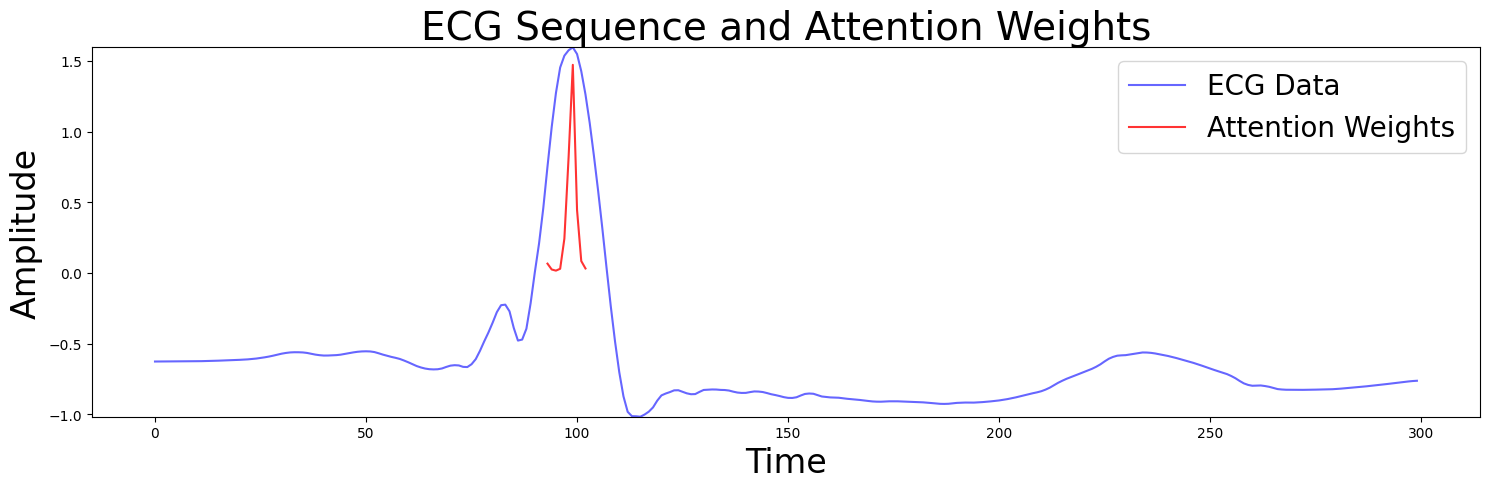

In [260]:
# Flatten ECG data for plotting
ecg_data = sample_inputs.reshape(sample_inputs.shape[0], -1)  # Shape (3, 300) for 10 segments of 30 timesteps each

plt.figure(figsize=(15, 5))

attention_y_offset = 1
i = 0  # Index for the first sample

# Plot ECG data
plt.plot(ecg_data[i], label='ECG Data', color='blue', alpha=0.6)

# Overlay attention weights
scaled_attention = final_attention_weights[i].numpy().flatten()

attention_scale_factor = (max(ecg_data[i]) - min(ecg_data[i])) * 1.3  
scaled_attention *= attention_scale_factor

attention_offset = 93  
attention_x_axis = np.arange(len(scaled_attention)) + attention_offset  
plt.ylim(min(ecg_data[i]), max(ecg_data[i]))


plt.plot(attention_x_axis, scaled_attention + min(ecg_data[i]) + attention_y_offset, label='Attention Weights', color='red', alpha=0.8)


plt.title('ECG Sequence and Attention Weights', fontsize=28)  
plt.xlabel('Time', fontsize=24)  
plt.ylabel('Amplitude', fontsize=24)  
plt.legend(fontsize=20)  
plt.tight_layout()
plt.show()


In [ ]:
# evaluate the model
train_loss, train_acc = model.evaluate(X_train_reshaped, Y_train, verbose=0)
test_loss, test_acc = model.evaluate(x_test_reshaped, y_test, verbose=0)
print('Training Accuracy: %.2f, Test Accuracy: %.2f' % (train_acc*100, test_acc*100))
print('Training Loss: %.2f, Test Loss: %.2f' % (train_loss*100, test_loss*100))

Training Accuracy: 97.40, Test Accuracy: 97.88
Training Loss: 7.85, Test Loss: 7.85
